In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as ophys_formatting
import brain_observatory_utilities.utilities.general_utilities as utilities

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

In [2]:
datafolder = "D:\\neuromatch2024\\datasets\\project\\Allen\\temp\\"
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=datafolder)

ophys_experiment_ids = [854759890, 854759894, 854759896, 854759898]

experiments = {}
# ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(
        ophys_experiment_id
    )

c:\Users\bosem\miniconda3\envs\allenSDK\lib\site-packages\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
c:\Users\bosem\miniconda3\envs\allenSDK\lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  retur

In [3]:
neural_data = []
for ophys_experiment_id in ophys_experiment_ids:
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys_formatting.build_tidy_cell_df(this_experiment)

    # add some columns with metadata for the experiment
    metadata_keys = [
        "ophys_experiment_id",
        "ophys_session_id",
        "targeted_structure",
        "imaging_depth",
        "equipment_name",
        "cre_line",
        "mouse_id",
        "sex",
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[
            metadata_key
        ]

    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)

# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

In [21]:
ophys_experiment_id = 854759890

In [22]:
nd = neural_data[neural_data.ophys_experiment_id == ophys_experiment_id].reset_index(drop=True)
nd

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,10.52216,0.400583,0.0,0.000000e+00,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
1,10.61538,0.126125,0.0,0.000000e+00,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
2,10.70860,-0.083087,0.0,0.000000e+00,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
3,10.80182,0.158960,0.0,0.000000e+00,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
4,10.89504,0.301507,0.0,0.000000e+00,1080852071,1086550481,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144988,4517.16339,-0.121875,0.0,6.377939e-112,1080852093,1086551301,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
144989,4517.25664,0.245187,0.0,3.772254e-126,1080852093,1086551301,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
144990,4517.34990,0.187690,0.0,3.063470e-141,1080852093,1086551301,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
144991,4517.44316,0.247769,0.0,3.416005e-157,1080852093,1086551301,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M


In [23]:
stimulus_table = experiments[ophys_experiment_id].stimulus_presentations.reset_index()
stimulus_table.head()

,stimulus_presentations_id,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,active,stimulus_name,is_sham_change
0,0,0,initial_gray_screen_5min,-99,NaN,-99,310.569786,0.000000,310.569786,0,17985,False,<NA>,<NA>,-99,0,-99,False,spontaneous,False
1,1,1,change_detection_behavior,0,im000,-99,0.250210,310.569786,310.819996,17985,18000,False,False,False,-99,1,0,True,Natural_Images_Lum_Matched_set_ophys_6_2017,False
2,2,1,change_detection_behavior,0,im000,-99,0.250200,311.320396,311.570596,18030,18045,False,False,False,-99,2,0,True,Natural_Images_Lum_Matched_set_ophys_6_2017,False
3,3,1,change_detection_behavior,0,im000,-99,0.250170,312.071016,312.321186,18075,18090,False,False,False,-99,3,1,True,Natural_Images_Lum_Matched_set_ophys_6_2017,False
4,4,1,change_detection_behavior,0,im000,-99,0.250190,312.821616,313.071806,18120,18135,False,False,False,-99,4,1,True,Natural_Images_Lum_Matched_set_ophys_6_2017,False


In [24]:
stimulus_table[stimulus_table.active]

,stimulus_presentations_id,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,active,stimulus_name,is_sham_change
1,1,1,change_detection_behavior,0,im000,-99,0.25021,310.569786,310.819996,17985,18000,False,False,False,-99,1,0,True,Natural_Images_Lum_Matched_set_ophys_6_2017,False
2,2,1,change_detection_behavior,0,im000,-99,0.25020,311.320396,311.570596,18030,18045,False,False,False,-99,2,0,True,Natural_Images_Lum_Matched_set_ophys_6_2017,False
3,3,1,change_detection_behavior,0,im000,-99,0.25017,312.071016,312.321186,18075,18090,False,False,False,-99,3,1,True,Natural_Images_Lum_Matched_set_ophys_6_2017,False
4,4,1,change_detection_behavior,0,im000,-99,0.25019,312.821616,313.071806,18120,18135,False,False,False,-99,4,1,True,Natural_Images_Lum_Matched_set_ophys_6_2017,False
5,5,1,change_detection_behavior,0,im000,-99,0.25021,313.572196,313.822406,18165,18180,False,False,False,-99,5,1,True,Natural_Images_Lum_Matched_set_ophys_6_2017,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4800,4800,1,change_detection_behavior,4,im045,-99,0.25022,3913.578346,3913.828566,233989,234004,False,False,False,-99,1,430,True,Natural_Images_Lum_Matched_set_ophys_6_2017,False
4801,4801,1,change_detection_behavior,4,im045,-99,0.25018,3914.328936,3914.579116,234034,234049,False,False,False,-99,2,430,True,Natural_Images_Lum_Matched_set_ophys_6_2017,False
4802,4802,1,change_detection_behavior,4,im045,-99,0.25019,3915.079546,3915.329736,234079,234094,False,False,False,-99,3,430,True,Natural_Images_Lum_Matched_set_ophys_6_2017,False
4803,4803,1,change_detection_behavior,4,im045,-99,0.25023,3915.830156,3916.080386,234124,234139,False,False,False,-99,4,430,True,Natural_Images_Lum_Matched_set_ophys_6_2017,False


In [25]:
stimulus_table.is_image_novel.unique()

<BooleanArray>
[<NA>, False]
Length: 2, dtype: boolean

In [26]:
licks = experiments[ophys_experiment_id].licks
licks.head()

,timestamps,frame
0,68.90307,3499
1,77.14313,3993
2,84.09879,4410
3,85.31647,4483
4,94.64071,5042


In [27]:
rewards = experiments[ophys_experiment_id].rewards
rewards

,volume,timestamps,auto_rewarded
0,0.005,318.95740,True
1,0.005,328.69873,True
2,0.005,337.73943,True
3,0.005,354.25289,True
4,0.005,364.74479,True
5,0.007,389.03134,False
6,0.007,425.84472,False
7,0.007,461.15690,False
8,0.007,470.09753,False
9,0.007,501.00608,False


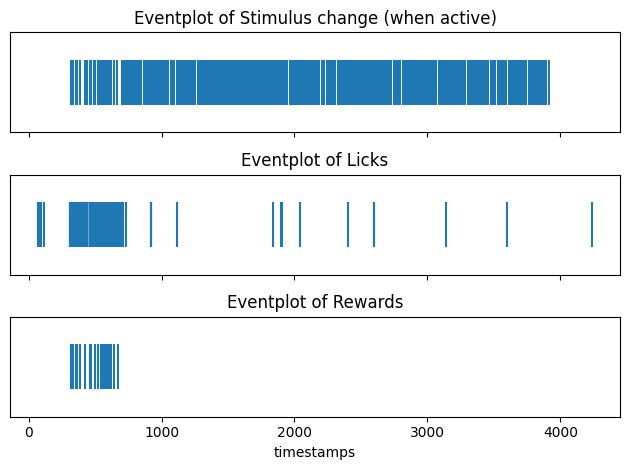

In [39]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].eventplot(stimulus_table[(stimulus_table.is_change) & (stimulus_table.active)].start_time)
ax[1].eventplot(licks.timestamps)
ax[2].eventplot(rewards.timestamps)

ax[2].set_xlabel("timestamps")

ax[0].set_title("Eventplot of Stimulus change (when active)")
ax[1].set_title("Eventplot of Licks")
ax[2].set_title("Eventplot of Rewards");

ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])

plt.tight_layout()

In [31]:
experiments[ophys_experiment_id].licks

,timestamps,frame
0,68.90307,3499
1,77.14313,3993
2,84.09879,4410
3,85.31647,4483
4,94.64071,5042
...,...,...
484,2595.66644,154981
485,2597.96832,155119
486,3139.61054,187591
487,3600.53690,215224


In [32]:
for ophys_experiment_id in ophys_experiment_ids:
    print(ophys_experiment_id)
    print(experiments[ophys_experiment_id].licks.head())

854759890
   timestamps  frame
0    68.90307   3499
1    77.14313   3993
2    84.09879   4410
3    85.31647   4483
4    94.64071   5042
854759894
   timestamps  frame
0    68.90307   3499
1    77.14313   3993
2    84.09879   4410
3    85.31647   4483
4    94.64071   5042
854759896
   timestamps  frame
0    68.90307   3499
1    77.14313   3993
2    84.09879   4410
3    85.31647   4483
4    94.64071   5042
854759898
   timestamps  frame
0    68.90307   3499
1    77.14313   3993
2    84.09879   4410
3    85.31647   4483
4    94.64071   5042
